# Intro

Juan Nunez-Iglesias  
Victorian Life Sciences Computation Initiative (VLSCI)  
University of Melbourne  

# Quick example: gene expression, without numpy


|        | Cell type A | Cell type B | Cell type C | Cell type D |
|--------|-------------|-------------|-------------|-------------|
| Gene 0 | 100         | 200         | 50          | 400         |
| Gene 1 | 50          | 0           | 0           | 100         |
| Gene 2 | 350         | 100         | 50          | 200         |

In [2]:
gene0 = [100, 200, 50, 400]
gene1 = [50, 0, 0, 100]
gene2 = [350, 100, 50, 200]
expression_data = [gene0, gene1, gene2]

Why is this a bad idea?

# Now with NumPy

In [3]:
import numpy as np
a = np.array(expression_data)
print(a)

[[100 200  50 400]
 [ 50   0   0 100]
 [350 100  50 200]]


We are going to:

* Obtain an *RPKM* expression matrix
* Quantile normalize the data

using the awesome power of NumPy

# Inside a numpy ndarray

In [4]:
def print_info(a):
    print('number of elements:', a.size)
    print('number of dimensions:', a.ndim)
    print('shape:', a.shape)
    print('data type:', a.dtype)
    print('strides:', a.strides)
    print('flags:')
    print(a.flags)
    
print_info(a)

number of elements: 12
number of dimensions: 2
shape: (3, 4)
data type: int64
strides: (32, 8)
flags:
  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False


In [5]:
print(a.data)

In [6]:
abytes = a.ravel().view(dtype=np.uint8)
print(a)
print(a.ravel())

[[100 200  50 400]
 [ 50   0   0 100]
 [350 100  50 200]]
[100 200  50 400  50   0   0 100 350 100  50 200]


In [7]:
print_info(abytes)

number of elements: 96
number of dimensions: 1
shape: (96,)
data type: uint8
strides: (1,)
flags:
  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False


In [13]:
print(abytes[:24])
np.array([300]).view(dtype=np.int0)

[100   0   0   0   0   0   0   0 200   0   0   0   0   0   0   0  50   0
   0   0   0   0   0   0]


array([300])

### Example: take the transpose of `a`

In [14]:
print_info(a)

number of elements: 12
number of dimensions: 2
shape: (3, 4)
data type: int64
strides: (32, 8)
flags:
  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False


In [15]:
print_info(a.T)

number of elements: 12
number of dimensions: 2
shape: (4, 3)
data type: int64
strides: (8, 32)
flags:
  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False


In [17]:
big_3d_image = np.random.rand(250, 250, 250)

In [19]:
print_info(big_3d_image)

number of elements: 15625000
number of dimensions: 3
shape: (250, 250, 250)
data type: float64
strides: (500000, 2000, 8)
flags:
  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False


In [20]:
%%timeit
for i in range(big_3d_image.shape[0]):
    big_3d_image[i, :, :] *= 5

10 loops, best of 3: 24.5 ms per loop


In [21]:
%%timeit
for i in range(big_3d_image.shape[2]):
    big_3d_image[:, :, i] *= 5

1 loops, best of 3: 179 ms per loop


### Example: skipping rows and columns with *slicing*

In [22]:
print(a)

[[100 200  50 400]
 [ 50   0   0 100]
 [350 100  50 200]]


In [24]:
print(a[:2])

[[100 200  50 400]
 [ 50   0   0 100]]


In [28]:
print(a[::2,::2])

[[100  50]
 [350  50]]


In [29]:
print_info(a.T)

number of elements: 12
number of dimensions: 2
shape: (4, 3)
data type: int64
strides: (8, 32)
flags:
  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False


In [30]:
print_info(a.T[::2])

number of elements: 6
number of dimensions: 2
shape: (2, 3)
data type: int64
strides: (16, 32)
flags:
  C_CONTIGUOUS : False
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False


In [31]:
print_info(a.T[::2, ::2])

number of elements: 4
number of dimensions: 2
shape: (2, 2)
data type: int64
strides: (16, 64)
flags:
  C_CONTIGUOUS : False
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False


### Getting a copy

In [32]:
b = a

In [33]:
print(b)

[[100 200  50 400]
 [ 50   0   0 100]
 [350 100  50 200]]


In [34]:
a[0, 0] = 5
print(b)
a[0, 0] = 100

[[  5 200  50 400]
 [ 50   0   0 100]
 [350 100  50 200]]


# Advanced operations: axis-wise evaluation

In [36]:
expr = np.load('expr.npy')

In [38]:
print_info(expr)

number of elements: 7687500
number of dimensions: 2
shape: (20500, 375)
data type: uint32
strides: (4, 82000)
flags:
  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False


This has the raw read count data. However, each sample gets a different number of reads, so we want to normalize by the *library size*, which is the total number of reads across a column.

The `np.sum` function returns the sum of all the elements of an array. With the `axis` argument, you can take the sum *along the given axis*.

In [39]:
lib_size = np.sum(expr, axis=0)

### Exercise

Generate a 10 x 3 array of random numbers. From each row, pick the number closest to 0.75. Make use of np.abs and np.argmax to find the column j which contains the closest element in each row.

In [56]:
%%timeit
a = np.random.rand(3000,1000)
dist = np.abs(a-0.75)

#print(a)
#print(dist)

mins = np.argmax(1/dist, axis=1)

#print(mins)

10 loops, best of 3: 59.5 ms per loop


In [60]:
a = np.random.rand(10,3)
dist = np.abs(a-0.75)

#print(a)
#print(dist)

mins = np.argmax(-dist, axis=1)

print(a[range(10), mins])

[ 0.72833718  0.67456203  0.16841496  0.88934851  0.43892387  0.9783102
  0.89204236  0.65758459  0.4501669   0.68793118]


# Advanced operations: broadcasting

In order to normalize every column by its corresponding library size, we have to *align* the two arrays' axes: each dimension must be either the same size, or one of the arrays must have size 1. Use `np.newaxis` to match the dimensions.

In [62]:
print(expr.shape)
print(lib_size.shape)
print(lib_size[np.newaxis, :].shape)

(20500, 375)
(375,)
(1, 375)


However, NumPy will automatically prepend singleton dimensions until the array shapes match or there is an error:

In [63]:
np.all(expr / lib_size ==
       expr / lib_size[np.newaxis, :])

True

In [64]:
expr_lib = expr / lib_size

We also multiply by $10^6$ in order to keep the numbers on a readable scale (reads per million reads).

In [65]:
expr_lib *= 1e6

Finally, longer genes are more likely to produce reads. So we normalize by the gene length (in kb) to produce a measure of expression called Reads Per Kilobase per Million reads (RPKM).

In [79]:
gene_len = np.load('gene-lens.npy')
print_info(gene_len)
print('-------')
print_info(gene_len[:, np.newaxis])

number of elements: 20500
number of dimensions: 1
shape: (20500,)
data type: int64
strides: (8,)
flags:
  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False
-------
number of elements: 20500
number of dimensions: 2
shape: (20500, 1)
data type: int64
strides: (8, 0)
flags:
  C_CONTIGUOUS : False
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False


In [81]:
np.sum(
    [[1,2,3,4],
     [5,6,7,8]], axis=1
)

array([10, 26])

### Exercise: broadcast `expr_lib` and `gene_len` together to produce RPKM

In [83]:
rpkm = expr_lib / (gene_len[:, np.newaxis] / 1e3)
print_info(rpkm)

number of elements: 7687500
number of dimensions: 2
shape: (20500, 375)
data type: float64
strides: (8, 164000)
flags:
  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False


In [88]:
from matplotlib import pyplot as plt
from scipy import stats

def plot_col_density(data, xlim=None, *args, **kwargs):
    # Use gaussian smoothing to estimate the density
    density_per_col = [stats.kde.gaussian_kde(col) for col in data.T]
    if xlim is not None:
        m, M = xlim
    else:
        m, M = np.min(data), np.max(data)
    x = np.linspace(m, M, 100)

    plt.figure()
    for density in density_per_col:
        plt.plot(x, density(x), *args, **kwargs)
    plt.xlabel('log-counts')
    plt.ylabel('frequency')
    if xlim is not None:
        plt.xlim(xlim)
    plt.show()


In [89]:
%matplotlib inline

In [90]:
plt.style.use('ggplot')

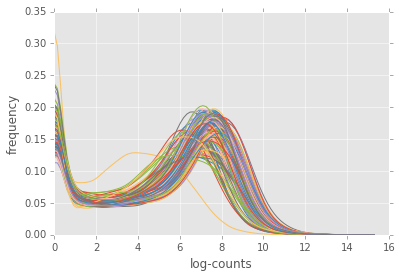

In [91]:
plot_col_density(np.log(expr+1))

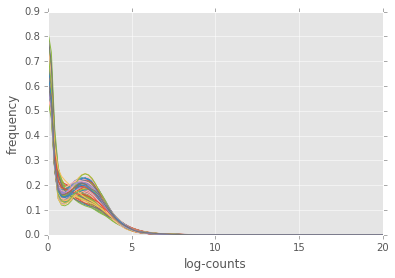

In [93]:
plot_col_density(np.log(rpkm + 1), xlim=(0, 20))

### Exercise: 3D broadcasting

Below, produce the array containing the sum of every element in `x` with every element in `y`

In [95]:
y = np.random.randint(10, size=8)
print(y)

[9 2 5 8 7 2 0 1]


In [99]:
x = np.random.rand(3, 5)
y = np.random.randint(10, size=8)
z = x[:,:,np.newaxis] + y[np.newaxis, np.newaxis, :]

print_info(z)
print('x:')
print(x)
print('y:')
print(y)
print('z[:,:,0]')
print(z[:,:,0])
print('z[:,:,1]')
print(z[:,:,1])

number of elements: 120
number of dimensions: 3
shape: (3, 5, 8)
data type: float64
strides: (320, 64, 8)
flags:
  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False
x:
[[ 0.31366905  0.45023178  0.53442256  0.69656874  0.08435853]
 [ 0.41921627  0.6672999   0.09802789  0.99167979  0.31849169]
 [ 0.35722506  0.9311274   0.83774696  0.29146393  0.09388558]]
y:
[9 2 8 7 8 3 0 4]
z[:,:,0]
[[ 9.31366905  9.45023178  9.53442256  9.69656874  9.08435853]
 [ 9.41921627  9.6672999   9.09802789  9.99167979  9.31849169]
 [ 9.35722506  9.9311274   9.83774696  9.29146393  9.09388558]]
z[:,:,1]
[[ 2.31366905  2.45023178  2.53442256  2.69656874  2.08435853]
 [ 2.41921627  2.6672999   2.09802789  2.99167979  2.31849169]
 [ 2.35722506  2.9311274   2.83774696  2.29146393  2.09388558]]


### Exercise: explicit broadcasting and stride tricks

Use `np.broadcast_arrays` to get the same-shape arrays that numpy adds together. Then use `print_info` on the output. Notice anything weird?

In [100]:
xx, yy = np.broadcast_arrays(x[..., np.newaxis], y)

In [102]:
print_info(xx)
print('---')
print_info(yy)

number of elements: 120
number of dimensions: 3
shape: (3, 5, 8)
data type: float64
strides: (40, 8, 0)
flags:
  C_CONTIGUOUS : False
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False
---
number of elements: 120
number of dimensions: 3
shape: (3, 5, 8)
data type: int64
strides: (0, 0, 8)
flags:
  C_CONTIGUOUS : False
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False


yy has stride (0,0, 8) -> numpy does not actually store the array, but only vector, saves memory

## Stride tricks

By manipulating the shape and strides of an array, we can produce a "virtual" array much bigger than its memory usage:

In [ ]:
def repeat(arr, n):
    return np.lib.stride_tricks.as_strided(arr,
                                           shape=(n,) + arr.shape,
                                           strides=(0,) + arr.strides)

In [103]:
#repeat(np.random.rand(5), 4)
np.lib.stride_tricks.as_strided??

### Exercise: `np.lib.stride_tricks.as_strided`

Use `as_strided` to produce a sliding-window view of a 1D array.

In [114]:
def sliding_window(arr, size=2):
    """Produce an array of sliding window views of `arr`
    
    Parameters
    ----------
    arr : 1D array, shape (N,)
        The input array.
    size : int, optional
        The size of the sliding window.
        
    Returns
    -------
    arr_slide : 2D array, shape (N - size - 1, size)
        The sliding windows of size `size` of `arr`.
        
    Examples
    --------
    >>> a = np.array([0, 1, 2, 3])
    >>> sliding_window(a, 2)
    array([[0, 1],
           [1, 2],
           [2, 3]])
    """
    
    # beware: this code is wrooon- dstride size is hardcoded, 
    # so it only works with data types with the size 8 bytes.
    # get the original stride size and use it here to fix!!
    return np.lib.stride_tricks.as_strided(arr, shape=(arr.size+1-size, size), strides=(8,8))

In [113]:
# test your code here
windows = sliding_window(np.arange(8).astype(np.float32), 3)
print(windows)
print_info(windows)

[[  0.00000000e+00   2.00000000e+00   4.00000000e+00]
 [  2.00000000e+00   4.00000000e+00   6.00000000e+00]
 [  4.00000000e+00   6.00000000e+00   1.16263549e+27]
 [  6.00000000e+00   1.16263549e+27   6.86636248e-44]
 [  1.16263549e+27   6.86636248e-44   4.20389539e-45]
 [  6.86636248e-44   4.20389539e-45   4.20389539e-45]]
number of elements: 18
number of dimensions: 2
shape: (6, 3)
data type: float32
strides: (8, 8)
flags:
  C_CONTIGUOUS : False
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False


# Fancy indexing

You can index arrays with slicing, but also with boolean arrays (including broadcasting!), integer arrays, and individual indices along multiple dimensions.

In [115]:
values = np.array([0, 5, 99])
selector = np.random.randint(0, 3, size=(3, 4))
print(selector)
print(values[selector])

[[1 0 2 2]
 [0 0 1 0]
 [0 1 2 1]]
[[ 5  0 99 99]
 [ 0  0  5  0]
 [ 0  5 99  5]]


### Exercise: quantile normalization

Quantile Normalization(https://en.wikipedia.org/wiki/Quantile_normalization) is a method to align distributions. Implement it using NumPy axis-wise operations and fancy indexing.

*Hint: look for documentation for `scipy.mstats.rankdata`, `np.sort`, and `np.argsort`.*

In [154]:
def qnorm(x):
    """Quantile normalize an input matrix.
    
    Parameters
    ----------
    x : 2D array of float, shape (M, N)
        The input data, with each column being a
        distribution to normalize.
        
    Returns
    -------
    xn : 2D array of float, shape (M, N)
        The normalized data.
        
    """
    
    import scipy
    xn = np.copy(x) # replace this by normalizing code
    ranks = np.round(scipy.stats.mstats.rankdata(xn, axis=0) - 1).astype(int)
    sort = np.sort(xn, axis=0)
    mean = np.mean(sort, axis=1)
    #for i in range(mean.size):
    #    ranks[ranks == i] = mean[i]
    #rankarg = np.argsort(ranks, axis=0)
    #xn[rankarg] = mean[:,np.newaxis]
    
    return mean[ranks]


In [153]:
testx = np.array([[5,    4,    3],
         [2,    1,    4],
         [3,    4,    6],
         [4,    2,    8]])

qnorm(testx)


array([[ 5.66666667,  4.66666667,  2.        ],
       [ 2.        ,  2.        ,  3.        ],
       [ 3.        ,  4.66666667,  4.66666667],
       [ 4.66666667,  3.        ,  5.66666667]])

In [155]:
logexpr = np.log(expr + 1)
logrpkm = np.log(rpkm + 1)

In [156]:
logexprn = qnorm(logexpr)
logrpkmn = qnorm(logrpkm)

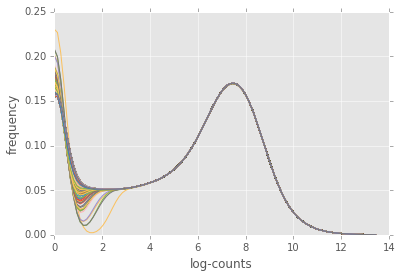

In [157]:
plot_col_density(logexprn)

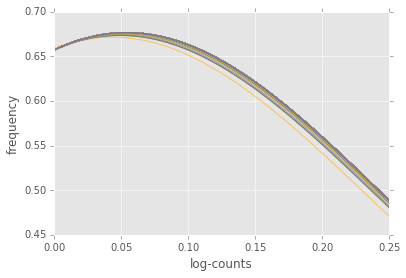

In [158]:
plot_col_density(logrpkmn, xlim=(0, 0.25))

## Advanced exercise Jack's dilemma

(If time permits.)

```email
Date: Wed, 16 Jul 2008 16:45:37 -0500
From: Jack Cook
To: <numpy-discussion@scipy.org>
Subject: Numpy Advanced Indexing Question
```

Greetings,

I have an I,J,K 3D volume of amplitude values at regularly sampled
time intervals. I have an I,J 2D slice which contains a time (K)
value at each I, J location. What I would like to do is extract a
subvolume at a constant +/- K window around the slice. Is there an
easy way to do this using advanced indexing or some other method?
Thanks in advanced for your help.

-- Jack

In [ ]:
# "data"

ni, nj, nk = (10, 15, 20)
amplitude = np.random.rand(ni, nj, nk)
horizon = np.random.randint(5, 15, size=(ni, nj))

## Even more advanced: NumPy Array Interface

An author of a foreign package (included with the exercizes as
``problems/mutable_str.py``) provides a string class that
allocates its own memory:

```ipython
In [1]: from mutable_str import MutableString
In [2]: s = MutableString('abcde')
In [3]: print s
abcde
```

You'd like to view these mutable (*mutable* means the ability to modify in place)
strings as ndarrays, in order to manipulate the underlying memory.

Add an __array_interface__ dictionary attribute to s, then convert s to an
ndarray. Numerically add "2" to the array (use the in-place operator ``+=``).

Then print the original string to ensure that its value was modified.

> **Hint:** Documentation for NumPy's ``__array_interface__``
  may be found [in the online docs](http://docs.scipy.org/doc/numpy/reference/arrays.interface.html).

Here's a skeleton outline:

In [ ]:
import numpy as np
from mutable_str import MutableString

s = MutableString('abcde')

# --- EDIT THIS SECTION ---

# Create an array interface to this foreign object
s.__array_interface__ = {'data' : (XXX, False), # (ptr, is read_only?)
                         'shape' : XXX,
                         'typestr' : '|u1', # typecode unsigned character
                         }

# --- EDIT THIS SECTION ---

print 'String before converting to array:', s
sa = np.asarray(s)

print 'String after converting to array:', sa

sa += 2
print 'String after adding "2" to array:', s